In [9]:
#Model ROBERTA Spanish

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from bs4 import BeautifulSoup
import torch
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from bs4 import BeautifulSoup
import re,string 
from sklearn.metrics import classification_report,confusion_matrix
from string import punctuation
from nltk.corpus import wordnet
import torch
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

MAX_LEN = 32

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)

(4340, 2)
(1447, 2)


In [10]:
#Environment stopwords for train
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_train['review']=df_train['review'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [11]:
#Environment stopwords for dev
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_dev['review']=df_dev['review'].apply(denoise_text)

In [12]:
X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]

In [13]:
# Tokenization

tokenizer = RobertaTokenizer.from_pretrained('roberta-base',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_dev_inputs, X_dev_masks = preprocessing(X_dev)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 32


In [14]:
#Data loaders
batch_size = 8

y_train_labels = torch.tensor(y_train.values)
y_dev_labels = torch.tensor(y_dev.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_dev_inputs, X_dev_masks, y_dev_labels)

In [15]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-6)

epochs=4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [16]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [17]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 4 =======
======= Epoch 2 / 4 =======
======= Epoch 3 / 4 =======
======= Epoch 4 / 4 =======


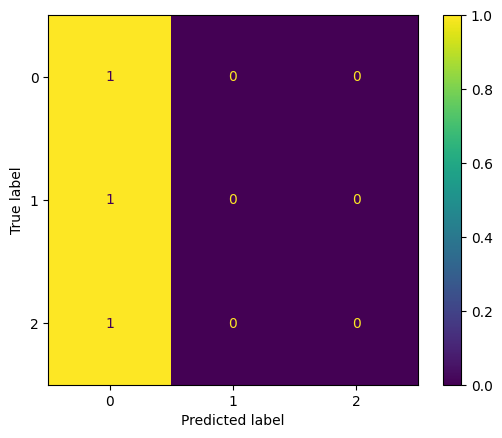

              precision    recall  f1-score   support

           1       0.41      1.00      0.59       599
           2       0.00      0.00      0.00       440
           3       0.00      0.00      0.00       408

    accuracy                           0.41      1447
   macro avg       0.14      0.33      0.20      1447
weighted avg       0.17      0.41      0.24      1447



/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)

        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion


        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))





#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)